# 量子近似优化算法

## 概述

**量子近似优化算法**（Quantum Approximate Optimization Algorithm，QAOA）是利用量子计算机来近似解决组合优化问题的量子算法，最早由Farhi等人于2014年提出。在本文档里，我们将利用QAOA算法来解决最大割问题（Max-Cut），来熟悉MindQuantum中量子线路的搭建和训练。

- 组合优化问题

    组合优化问题指的是在有限的可行解集合中找出最优解的一类优化问题，它是运筹学中的一个重要分支，在网络通信、物流管理、交通规划等行业发挥着重要作用。一些典型的组合优化问题有：旅行商问题（Traveling Salesman Problem）,背包问题(Knapsack Problem)，图着色问题（Graph coloring Problem），最大割问题（Max-cut）等。
- 近似算法

    大多的组合优化问题都可以归为所谓的NP-hard问题，人们普遍认为不存在求精确最优解的多项式时间算法。而近似算法指的是能在多项式时间内找到问题的一个**近似解**的算法。

### 量子背景

- 哈密顿量

    在量子力学中，哈密顿量$\hat{H}$对应于系统总能量，它决定了量子态$\Psi$如何演化，这便是大名鼎鼎的薛定谔方程：

$$
\hat{H} \Psi=i\hbar\frac{\partial}{\partial t}\Psi
$$

 当态$\Psi$处于某些特别的状态时，哈密顿量$\hat{H}$作用上去后$\Psi$维持不变，一般我们称之为本征态。此时的薛定谔方程成为定态薛定谔方程：

$$
\hat{H} \Psi=E\Psi
$$

E代表这个稳定态的能量，其中能量最小的态我们称为**基态**。举例说明，让$\hat{H}$取为$-X$算符，那么$-X$作用在$|+\rangle=(|0\rangle+|1\rangle)/\sqrt{2}$上得到能量-1，意味着$|+\rangle$是其基态（注意区分`Hadamard`门$H$和哈密顿量$\hat{H}$)。

$$
\hat{H}=-\begin{pmatrix}
0 & 1 \\
1 & 0 
\end{pmatrix}
$$

 and

$$
-\begin{pmatrix}
0 & 1 \\
1 & 0 
\end{pmatrix}
\begin{pmatrix}
\frac{1}{\sqrt{2}}\\
\frac{1}{\sqrt{2}}
\end{pmatrix}=-1
\begin{pmatrix}
\frac{1}{\sqrt{2}}\\
\frac{1}{\sqrt{2}}
\end{pmatrix}
$$


- 量子绝热定理

    量子绝热定理指的是当系统的哈密顿量**演化足够缓慢**时，则系统会一直保持在其瞬时本征态。
    
![adiabatic](https://gitee.com/mindspore/mindquantum/raw/research/course/images/adiabatic_evl.png)
    
- 绝热演化

    那么我们利用该定理，我们可以来得到所需要哈密顿量$H_C$的基态，比如首先让系统处于$H_B$的基态。然后使得哈密顿量如下式随时间$t$缓慢演化：

$$
H(t)=(1-\frac{t}{T})H_B+(\frac{t}{T})H_C
$$

注意到当$t=0$时，哈密顿量完全是$H_B$，同时此时处于基态。当$t=T$时，$H(T)=H_C$使我们的目标哈密顿量。当选取的$T$足够大时（满足绝热条件），系统将始终处于$H(t)$的瞬时基态上，此时系统的量子态将从初始哈密顿量$H_B$的基态$|\psi (0)\rangle$绝热地演化到目标哈密顿量$H_C$的基态$|\psi (T)\rangle$上。






## Max-Cut问题描述

Max-Cut问题是图论中的一个NP-complete问题，它需要将一个图中的顶点分成两部分，并使得两部分被切割的边最多。如下图（a），一个图由五个顶点构成，相互连接的边$E$为```(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), (0, 4)```。为了使得被切割的边最多，我们尝试通过（b）图的分割，将1、2、4分为一组，0、3分成另一组，因此可得到被切割的边有5条。当图中顶点较少时，我们可以在较短时间内通过穷举法找到最大的切割边数，但当图中顶点增多时，我们很难找到有效的经典算法来解决Max-Cut问题。

![max cut](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/Max_Cut.png)



### 编码为量子问题
- 下面，我们介绍怎么将Max-Cut问题转化为量子中的哈密顿量基态能量求解的问题。由于所有节点被分成两组，我们将一组标记为+1，另一组标记为-1，此时被切割的边$\mathcal{C}$可以表示为：
$$
\mathcal{C}= \sum_{(i,j)\in E}\frac{1}{2}(1-Z_iZ_j)
$$
其中$E$是原图中存在的边，（i,j）代表$E$中一条边的两个顶点，$Z_i,Z_j$代表他们属于哪一组的标记，如果他们在同一组那么$Z_iZ_j=1\rightarrow(1-Z_iZ_j)=0$, 不贡献切割的边；而当他们不同的时候$Z_iZ_j=-1\rightarrow1/2(1-Z_iZ_j)=1$就刚好贡献出一条边。因此我们求和之后$\mathcal{C}$便代表了被切割的边。

- 现在，我们将$Z_i,Z_j$解释为我们的量子比特的测量的结果是+1（即处于$|0\rangle$态）还是-1（即处于$|1\rangle$态），同时让目标哈密顿量$H_C=-\mathcal{C}=\sum_{(i,j)\in E}\frac{1}{2}(Z_iZ_j-1)$，这样求解基态会对应$\mathcal{C}$最大的情况。

## QAOA量子线路
选取初始简单哈密顿量为

$$
H_B=\sum_i X_i
$$

并将量子线路制备到$H_B$的基态$|s\rangle=|+\rangle^{\otimes n}$，这里通过对所有量子比特作用`Hadamard`门即可实现。

然后缓慢地作用如下含时哈密顿量

$$
H(t)=(1-\frac{t}{T})H_B+(\frac{t}{T})H_C
$$

系统的量子态将从初始哈密顿量$H_B$的基态$|\psi (0)\rangle$绝热地演化到目标哈密顿量$H_C$的基态$|\psi (T)\rangle$上，即

$$
|\psi (T)\rangle=\mathcal{T}e^{-i\int^{T}_{0} H(t)dt}|\psi(0)\rangle
$$

也就是说，线路需要模拟的就是$\mathcal{T}e^{-i\int^{T}_{0} H(t)dt}$这一演化过程。接下来我们将对这个式子进行一些近似和化简，使其变为可以在量子线路中实现的形式。

考虑如下trotter公式

$$
\mathcal{T}e^{-i\int^T_0 H(t)dt}=\lim_{N\rightarrow \infty}\prod^N_{l=1}e^{-iH(t_l)\Delta t},\quad \Delta t=\frac{T}{N},\quad t_l=l\Delta t
$$

略去$O(\Delta t^2)$项，得到

$$
\mathcal{T}e^{-i\int^T_0 H(t)dt}\approx \lim_{N\rightarrow \infty}\prod^N_{l=1}e^{-iH_B(1-t_l/T)\Delta t}e^{-iH_C t_l\Delta t/T}
$$

令$\beta_l=(1-t_l/T)\Delta t$，$\gamma_l=t_l\Delta t/T$，并取$N$为一个有限大的整数，即得到QAOA的ansatz。

- 这里需要特别说明的是在绝热演化中$(1-t_l/T)\Delta t$是一系列固定的值，但QAOA是由此而来的启发式变分量子算法，在绝热演化的基础上将时间转化为可以变动的参数，通过在经典优化器里优化我们的参数$\beta_l,\gamma_l$使得哈密顿量最小。

$$
|\psi(\gamma,\beta)\rangle=\prod^p_{l=1}e^{-i\beta_l H_B}e^{-i\gamma_l H_C}|\psi_{in}\rangle
$$

因此我们需要搭建的ansatz线路由$U_C(\gamma)$和$U_B(\beta)$这两个酉变换交替构成，其中$U_C(\gamma)=e^{-i\gamma \sum_{\langle i,j\rangle}Z_i Z_j}$可以由`ZZ`门实现，$U_B(\beta)=e^{-i\beta \sum_i X_i}$则相当于在每个量子比特上作用一个`RX`旋转门，$\gamma$和$\beta$是可训练的参数。


![qaoa_circuit](https://gitee.com/mindspore/mindquantum/raw/research/course/images/qaoa_circuit.PNG)


## QAOA算法整体流程

1. 搭建QAOA量子线路，其中ansatz线路包含可以训练的参数
2. 初始化线路中的参数
3. 运行该量子线路，得到量子态$|\psi\rangle$
4. 计算目标哈密顿量$H_C$的期望值$\langle\psi|H_C|\psi\rangle$
5. 根据第4步的结果，使用Adam优化器优化线路中参数
6. 重复3-5步，直到第4步结果基本不再变化
7. 根据第4步的结果，算出目标问题的近似解

![Flowchart](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/QAOA_Flowchart.png)


光说不练假把式，讲解了这么多理论知识之后，下面让我们进行编程实战吧！
***
***



## 环境准备

本文档所需要的额外库：

- networkx

> `networkx`是创建、操作和研究复杂网络的结构、动态和功能库。可通过如下代码来进行安装。

```bash
pip3 install networkx
```
## 导入相关依赖

In [2]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, ZZ, RZ, RX , X
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import networkx as nx
import mindspore.nn as nn

## 搭建所需求解的图

通过`add_path`可在图中添加边。最后画出图的结构。

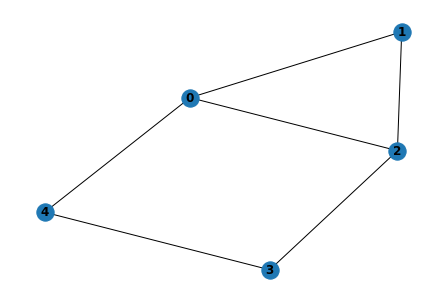

In [6]:
g = nx.Graph()
nx.add_path(g, [0, 1])
nx.add_path(g, [1, 2])
nx.add_path(g, [2, 3])
nx.add_path(g, [3, 4])
nx.add_path(g, [0, 4])
nx.add_path(g, [0, 2])
nx.draw(g, with_labels=True, font_weight='bold')

如上图，我们得到一个由5个节点和6条边构成的图结构。

接下来我们用穷举法来看看所有情况的切割边数。

In [4]:
for i in g.nodes:
    print('one size:', [i], 'cut=', nx.cut_size(g, [i]))            # 一组1个节点、另一组4个节点的所有情况
    for j in range(i):
        print('two size:', [i, j], 'cut=', nx.cut_size(g, [i, j]))  # 一组2个节点、另一组3个节点的所有情况

one size: [0] cut= 3
one size: [1] cut= 2
two size: [1, 0] cut= 3
one size: [2] cut= 3
two size: [2, 0] cut= 4
two size: [2, 1] cut= 3
one size: [3] cut= 2
two size: [3, 0] cut= 5
two size: [3, 1] cut= 4
two size: [3, 2] cut= 3
one size: [4] cut= 2
two size: [4, 0] cut= 3
two size: [4, 1] cut= 4
two size: [4, 2] cut= 5
two size: [4, 3] cut= 2


从以上结果可以看出，穷举法得到的最大切割边数为5，分别是(0,3|1,2,4)和（2,4|0,1,3），如果再对节点分组的左右进行区分，一共则有4个简并解。

## 搭建量子线路
ansatz线路由$U_C(\gamma)$和$U_B(\beta)$这两个酉变换交替构成，其中$U_C(\gamma)=e^{-i\gamma \sum_{\langle i,j\rangle}Z_i Z_j}$可以由`ZZ`门实现，$U_B(\beta)=e^{-i\beta \sum_i X_i}$则相当于在每个量子比特上作用一个`RX`旋转门，
* 搭建$U_C(\gamma)$对应的量子线路，由于$U_C(\gamma)=e^{-i\gamma \sum_{\langle i,j\rangle}Z_i Z_j}$中的$Z_i Z_j$项相互对易，我们可以简单的进行分解为$e^{-i\gamma Z_i Z_j}$，这便是`ZZ`门，它具体可以通过如下基础门实现：

In [5]:
ZZ_circ=Circuit()
ZZ_circ+=X.on(1,0)
ZZ_circ += RZ('2gamma').on(1)
ZZ_circ+=X.on(1,0)
ZZ_circ.svg()

* 通过内置的`ZZ`门搭建$U_C(\gamma)$对应的量子线路： 

In [5]:
def build_hc(g, para):
    hc = Circuit()                  # 创建量子线路
    for i in g.edges:
        hc += ZZ(para).on(i)        # 对图中的每条边作用ZZ门
    hc.barrier()                    # 添加Barrier以方便展示线路
    return hc

线路展示：

In [6]:
# pylint: disable=W0104
circuit = build_hc(g, 'gamma')
circuit.svg()

搭建$U_B(\beta)$对应的量子线路：

In [7]:
def build_hb(g, para):
    hb = Circuit()                  # 创建量子线路
    for i in g.nodes:
        hb += RX(para).on(i)        # 对每个节点作用RX门
    hb.barrier()                    # 添加Barrier以方便展示线路
    return hb

线路展示：

In [8]:
# pylint: disable=W0104
circuit = build_hb(g, 'beta')
circuit.svg()

实现了一层酉变换$U_B(\beta) U_C(\gamma)$的ansatz线路如下所示：

In [9]:
# pylint: disable=W0104
circuit = build_hc(g, 'gamma') + build_hb(g, 'beta')
circuit.svg()

为了使得最后优化的结果足够准确，我们需要将量子线路重复多次，因此我们通过如下函数搭建多层的训练网络：

In [10]:
def build_ansatz(g, p):                    # g是max-cut问题的图，p是ansatz线路的层数
    circ = Circuit()                       # 创建量子线路
    for i in range(p):
        circ += build_hc(g, f'g{i}')       # 添加Uc对应的线路，参数记为g0、g1、g2...
        circ += build_hb(g, f'b{i}')       # 添加Ub对应的线路，参数记为b0、b1、b2...
    return circ

构建图对应的哈密顿量$H_C=\sum_{(i,j)\in C}(Z_iZ_j-1)/2$（忽略常数项和系数）：

In [11]:
def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')  # 生成哈密顿量Hc
    return ham

### 生成完整的量子线路和图所对应的哈密顿量

这里我们选择`p = 4`，表示选用4层的QAOA量子线路，`ansatz`是求解该问题的量子线路，`init_state_circ`是将量子态制备到均匀叠加态（$H_B$的基态）上的量子线路。

In [12]:
# pylint: disable=W0104
p = 4
ham = Hamiltonian(build_ham(g))              # 生成哈密顿量
init_state_circ = UN(H, g.nodes)             # 生成均匀叠加态，即对所有量子比特作用H门
ansatz = build_ansatz(g, p)                  # 生成ansatz线路
circ = init_state_circ + ansatz              # 将初始化线路与ansatz线路组合成一个线路
circ.svg()

- **特别注意**：上述搭建只是辅助让大家理解，使用我们内置的MaxCutAnsatz直接根据图产生相应的QAOA线路：

In [25]:
from mindquantum.algorithm.nisq import MaxCutAnsatz
maxcut = MaxCutAnsatz([e for e in g.edges], 4) #第一个参数是包含图中所有边的列表，4代表需要的层数p。
maxcut.circuit.svg()

### 搭建待训练量子神经网络

由于该问题不需要编码层（Encoder）量子线路，我们这里使用`MQAnsatzOnlyLayer`作为待训练的量子神经网络，并采用`Adam`优化器。

In [13]:
import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

sim = Simulator('projectq', circ.n_qubits)                     # 创建模拟器，backend使用‘projectq’，能模拟5个比特（'circ'线路中包含的比特数）
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
net = MQAnsatzOnlyLayer(grad_ops)                              # 生成待训练的神经网络
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net = nn.TrainOneStepCell(net, opti)                     # 对神经网络进行一步训练

## 训练并展示结果

In [14]:
for i in range(200):
    cut = (len(g.edges) - train_net()) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
    if i%10 == 0:
        print("train step:", i, ", cut:", cut)  # 每训练10步，打印当前训练步数和当前得到的切割边数

train step: 0 , cut: [2.9992561]
train step: 10 , cut: [3.2545047]
train step: 20 , cut: [4.6659966]
train step: 30 , cut: [4.769455]
train step: 40 , cut: [4.810666]
train step: 50 , cut: [4.851624]
train step: 60 , cut: [4.871687]
train step: 70 , cut: [4.8753843]
train step: 80 , cut: [4.8829556]
train step: 90 , cut: [4.8867188]
train step: 100 , cut: [4.8897595]
train step: 110 , cut: [4.891304]
train step: 120 , cut: [4.891866]
train step: 130 , cut: [4.892021]
train step: 140 , cut: [4.892035]
train step: 150 , cut: [4.8920326]
train step: 160 , cut: [4.8920345]
train step: 170 , cut: [4.892037]
train step: 180 , cut: [4.892038]
train step: 190 , cut: [4.8920383]


根据上面的训练结果我们发现，该问题哈密顿量的基态能量对应的边切割数趋近于5。

* 最优参数

前面我们通过训练得到了量子线路中参数的最优值，下面，我们将最优参数提取出来并存储为字典类型，与之前线路中命名的参数一一对应。

In [15]:
pr = dict(zip(ansatz.params_name, net.weight.asnumpy())) # 获取线路参数
print(pr)

{'g0': -0.4650414, 'b0': 0.19532563, 'g1': 0.7809111, 'b1': -1.0047114, 'g2': 0.49899587, 'b2': -0.7529009, 'g3': 0.60482264, 'b3': -0.3672217}


### 概率图

我们将最优参数代入量子线路，通过对量子线路进行1000次采样，画出最终量子态在计算基矢下的概率分布：

In [16]:
# pylint: disable=W0104
circ.measure_all()                               # 为线路中所有比特添加测量门
sim.sampling(circ, pr=pr, shots=1000).svg()      # 运行线路1000次并打印结果

根据概率分布图我们发现，该Max-Cut问题具有四个简并解，每个解对应的概率大概为25%。

- `01001`：编号为1、2、4的顶点在左边，编号为0、3的顶点在右边(1,2,4|0,3)。
- `10110`：编号为0、3的顶点在左边，编号为1、2、4的顶点在右边(0,3|1,2,4)。
- `01011`：编号为2、4的顶点在左边，编号为0、1、3的顶点在右边(2,4|0,1,3)。
- `10100`：编号为0、1、3的顶点在左边，编号为2、4的顶点在右边(0,1,3|2,4)。

可以发现，以上结果与先前通过穷举法得到的结果相符。

## 量子绝热演化的优势

在经典的优化算法中，当陷入某个局部最小（图中橙色小球）时，由于壁垒特别高，可能爬不过去，无法达到全局最小。然而在量子力学中，即使是很高的壁垒，却可以通过量子隧穿的方式抵达壁垒后的区域，从而达到全局最优。

![tunnelling](https://gitee.com/mindspore/mindquantum/raw/research/course/images/tunnelling.png)


## 总结

这里介绍了有关量子近似优化算法QAOA的具体内容，并通过该算法来解决了Max-Cut问题，并得到了案例中的图对应的最大切割方案。此外我们还说明了QAOA算法是从量子绝热演化启发而来，以及它相对经典算法的优势。



> 本文档适用于CPU环境。
> 你可以在这里找到完整的可运行的样例代码：<https://gitee.com/mindspore/mindquantum/blob/master/tutorials/source/quantum_approximate_optimization_algorithm.py>。

# 小作业
请对本案例中问题画出QAOA层数为p=2的采样结果图，与文档中p=4的情况进行对比，它们有什么区别？如何理解这一现象？

## 参考文献

[1] Edward Farhi, Jeffrey Goldstone, and Sam Gutmann. [A Quantum Approximate Optimization Algorithm](https://arxiv.org/pdf/1411.4028.pdf)